# Group-based Regression Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [53]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [4]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

In [5]:
from pycaret.regression import *

In [6]:
import functions as f

In [7]:
from copy import deepcopy

# Quantum dots regression model

In [8]:
model_group_name = "quantum_dot"
group_name = "quantum_dots"

### Load the data and filter metal oxide instances

In [9]:
data_train_df = pd.read_csv("output/datasets/universal/data_regression_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_regression_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [10]:
data_df.shape

(11315, 20)

In [11]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [12]:
data_group_df.shape

(3013, 20)

In [13]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,Viability
0,CdSe,None,4.6,NaN,NaN,NaN,NaN,7.17,1.0,MC3T3-E1,Mouse,Bone,Preosteoblast,neonate,Normal,NaN,Others,NaN,quantum_dots,86.00
1,CdSe,None,5.2,NaN,NaN,NaN,NaN,0.00,24.0,Neuro­2a,Mouse,Brain,Neural,Adult,cancer,NaN,LDH,LDHrelease,quantum_dots,10.83
2,QDs,SGF,6.0,NaN,NaN,NaN,NaN,0.84,24.0,Caco_2,Human,Colon,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,quantum_dots,70.73
7,CdSe,None,2.2,NaN,NaN,NaN,NaN,0.19,12.0,JB6,Human,Blood,Lymphocyte,Adult,cancer,male,MTT,TetrazoliumSalt,quantum_dots,94.30
9,CdTe,None,2.6,NaN,NaN,NaN,NaN,3.00,24.0,K562,Human,BoneMarrow,Lymphoblast,Adult,cancer,female,MTT,TetrazoliumSalt,quantum_dots,35.00


### Create training set and test set

In [14]:
data_group_df = f.quantile_discretize(data_group_df, 'Viability')

In [15]:
splitter = setup(data = data_group_df, target = 'Viability_discrete',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = 123,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,Viability_discrete
2,Original Data,"(3013, 21)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,15
6,Transformed Train Set,"(2410, 18)"
7,Transformed Test Set,"(603, 18)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,True


In [16]:
data_group_train_df = get_config(variable="X_train").copy()
#data_group_train_df['Viability'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
#data_group_test_df['Viability'] = get_config(variable="y_test").copy()

In [17]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(2410, 18)
(603, 18)


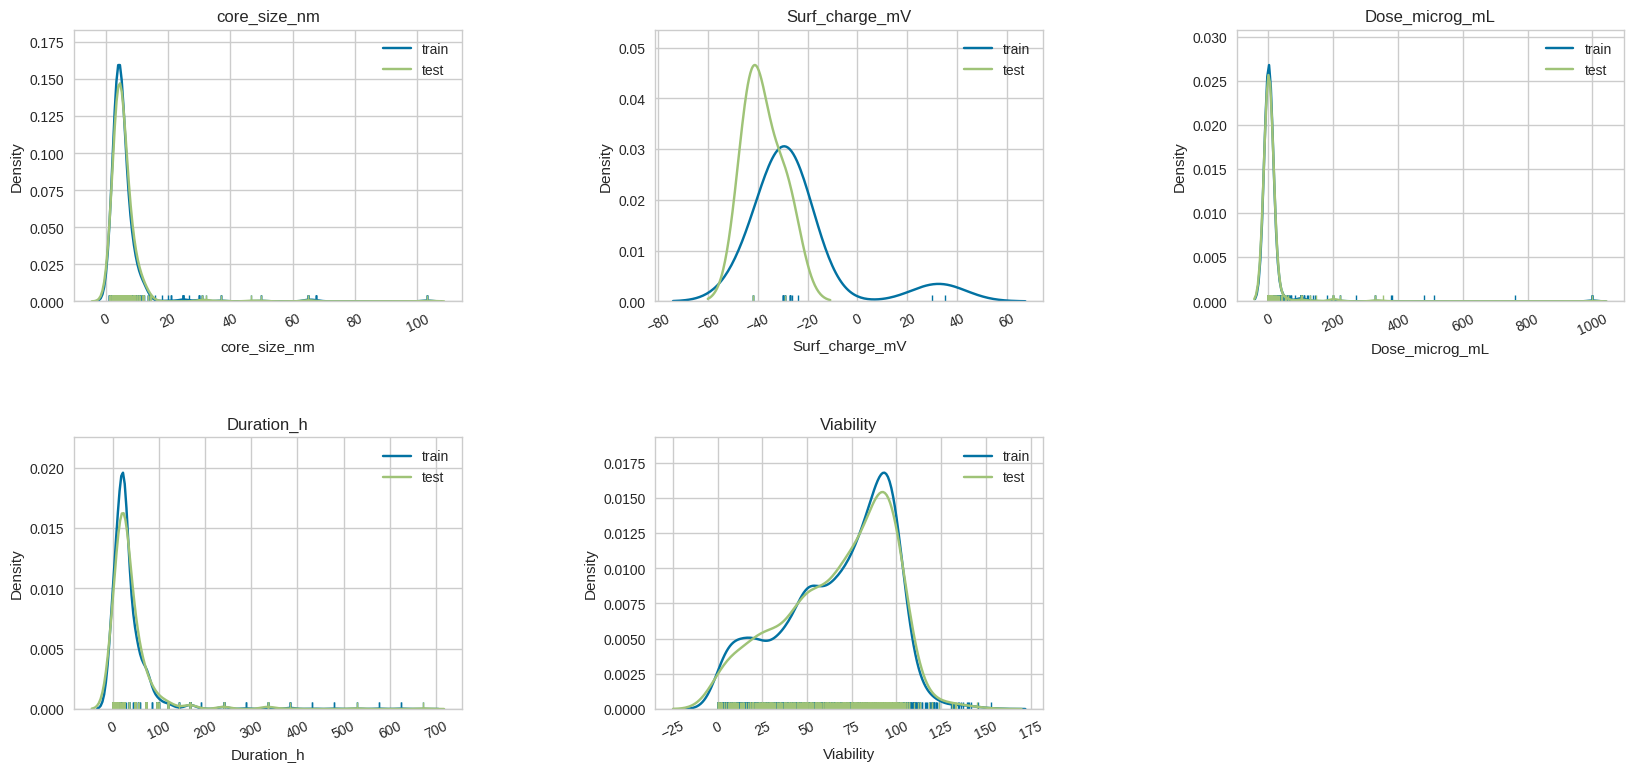

In [18]:
f.plot_distribution_train_test(data_group_train_df, data_group_test_df)

### Save cleaned datasets

In [19]:
data_group_train_df.to_csv('output/datasets/'+model_group_name+'/data_regression_train_df.csv', encoding='utf-8', index=False)

In [20]:
data_group_test_df.to_csv('output/datasets/'+model_group_name+'/data_regression_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [21]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'simple'
sc_numeric_imputation = 'median'

sc_normalize = True
sc_remove_outliers = False

### Define seeds

In [22]:
cv_inner_seed = 834
cv_outer_seed = 123

### Data Preprcoessing

In [23]:
stup = setup(data = data_group_train_df, target = 'Viability', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,
          
        fold = 5,

        # don't change the following
        session_id = cv_inner_seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'group_based')

set_config('seed', cv_inner_seed)

,Description,Value
0,session_id,834
1,Target,Viability
2,Original Data,"(2410, 18)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2410, 149)"


In [24]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(2410, 149)
(2410,)


In [25]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(2410, 149)
(2410,)


In [26]:
#set_config('X_train', get_config(variable="X").copy()) 
#set_config('y_train', get_config(variable="y").copy()) 
#print(get_config(variable="X_train").shape)
#print(get_config(variable="y_train").shape)

In [27]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(603, 149)
(603,)


In [28]:
#load_config('output/models/universal/regression_config.cfg')

In [29]:
data_train_transformed_df = get_config(variable="X").copy()
data_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [30]:
data_test_transformed_df = get_config(variable="X_test").copy()
data_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [31]:
data_train_transformed_df.to_csv('output/datasets/'+model_group_name+'/transformed/data_regression_train_transformed_df.csv', encoding='utf-8', index=False)
data_test_transformed_df.to_csv('output/datasets/'+model_group_name+'/transformed/data_regression_test_transformed_df.csv', encoding='utf-8', index=False)

## Double cross-validation

### Inner CV: 5-fold cross-validation for model selection / hyperparameter tuning for 8 models

In [32]:
model_names = ['lr', 'lasso', 'ridge', 'svm', 'rf', 'et', 'gbr', 'lightgbm']

In [33]:
inner_results = dict()
inner_results_tuned = dict()
outer_results = dict()
predicted_results = dict()
tuned_models = dict()
final_models = dict()

In [34]:
for model_name in model_names:

    default_model = create_model(model_name, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results[model_name] = results_df.copy()
    results_df.to_csv('output/models_results/'+model_group_name+'/' + 'regression_model_'+model_name+'_inner_cross_validation_results.tsv', 
                    index=False, encoding="utf-8", sep="\t")


    tuned_model = tune_model(default_model, choose_better = True, search_library = 'optuna', n_iter = 50, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results_tuned[model_name] = results_df.copy()
    results_df.to_csv('output/models_results/'+model_group_name+'/' + 'regression_model_'+model_name+'_tuned_inner_cross_validation_results.tsv', 
                    index=False, encoding="utf-8", sep="\t")
    
    tuned_models[model_name] = deepcopy(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19.11,608.44,24.67,0.34,0.71,0.88
1,18.96,649.08,25.48,0.31,0.75,1.00
2,18.28,583.85,24.16,0.35,0.69,0.90
3,17.56,550.18,23.46,0.32,0.55,0.71
4,18.70,594.64,24.39,0.36,0.68,1.18
Mean,18.52,597.24,24.43,0.34,0.67,0.93
Std,0.56,32.29,0.66,0.02,0.07,0.15


### Outer CV: 10-fold cross-validation for the tuned model

In [35]:
X = get_config(variable="X_train").copy()
y = get_config(variable="y_train").copy()

In [36]:
X.shape

(2410, 149)

In [37]:
y.shape

(2410,)

In [38]:
cv_outer = KFold(n_splits=10, shuffle=True, random_state=cv_outer_seed)

In [39]:
for model_name in model_names:
    scores = cross_val_score(tuned_models[model_name], X, y, cv=cv_outer)
    scores = np.round(scores, 2);
    outer_results[model_name] = scores.copy()
    
    with open('output/models_results/'+model_group_name+'/' + 'regression_model_'+model_name+'_tuned_outer_cross_validation_results.tsv', 'w', newline='') as file:
        for score in scores:
            file.write(str(score) + "\n")
        
    print(model_name + " scores: " + ', '.join(scores.astype('str')))
    print(model_name + " mean/std: " + str(np.round(scores.mean(),2)) + " / " + str(np.round(scores.std(), 2)))

    #with open(the_filename, 'r') as f:
    #    my_list = [line.rstrip('\n') for line in f]

lr scores: 0.04, -13.6, -7245.2, 0.18, 0.24, -30444.39, -282339.74, 0.16, -594.52, -11.05
lr mean/std: -32064.79 / 83913.01
lasso scores: 0.12, 0.07, 0.11, 0.17, 0.16, 0.04, 0.13, 0.16, 0.06, 0.08
lasso mean/std: 0.11 / 0.04
ridge scores: 0.08, 0.04, 0.14, 0.18, 0.22, 0.05, 0.11, 0.18, 0.12, 0.11
ridge mean/std: 0.12 / 0.06
svm scores: 0.17, 0.15, 0.11, 0.22, 0.18, 0.16, 0.23, 0.23, 0.06, 0.16
svm mean/std: 0.17 / 0.05
rf scores: 0.18, 0.42, 0.28, 0.37, 0.47, 0.25, 0.35, 0.48, 0.28, 0.31
rf mean/std: 0.34 / 0.09
et scores: 0.24, 0.25, 0.23, 0.3, 0.34, 0.21, 0.3, 0.33, 0.25, 0.3
et mean/std: 0.28 / 0.04
gbr scores: 0.26, 0.41, 0.31, 0.37, 0.49, 0.29, 0.39, 0.5, 0.28, 0.35
gbr mean/std: 0.36 / 0.08
[LightGBM] [Warning] bagging_fraction is set=0.48362937044189325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48362937044189325
[LightGBM] [Warning] feature_fraction is set=0.4227604230527039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42276042

In [54]:
for model_name in model_names:
    scores = cross_validate(tuned_models[model_name], X, y, cv=cv_outer, scoring=('r2','neg_root_mean_squared_error','neg_mean_absolute_error'))
    scores_r2 = np.round(scores['test_r2'], 2);
    scores_rmse = np.round(scores['test_neg_root_mean_squared_error'], 2);
    scores_mae = np.round(scores['test_neg_mean_absolute_error'], 2);
    outer_results[model_name] = scores.copy()
    
    with open('output/models_results/'+model_group_name+'/' + 'regression_model_'+model_name+'_tuned_outer_cross_validation_results.tsv', 'w', newline='') as file:
        file.write('R2\tRMSE\tMAE' + "\n")
        for idx, x in enumerate(scores_r2):
            file.write(str(scores_r2[idx]) + '\t' + str(scores_rmse[idx]) + '\t' + str(scores_mae[idx]) + "\n")

    print(model_name + " scores: " + ', '.join(scores_r2.astype('str')))
    print(model_name + " mean/std: " + str(np.round(scores_r2.mean(),2)) + " / " + str(np.round(scores_r2.std(), 2)))
    
    #with open(the_filename, 'r') as f:
    #    my_list = [line.rstrip('\n') for line in f]

lr scores: 0.04, -13.6, -7245.2, 0.18, 0.24, -30444.39, -282339.74, 0.16, -594.52, -11.05
lr mean/std: -32064.79 / 83913.01
lasso scores: 0.12, 0.07, 0.11, 0.17, 0.16, 0.04, 0.13, 0.16, 0.06, 0.08
lasso mean/std: 0.11 / 0.04
ridge scores: 0.08, 0.04, 0.14, 0.18, 0.22, 0.05, 0.11, 0.18, 0.12, 0.11
ridge mean/std: 0.12 / 0.06
svm scores: 0.17, 0.15, 0.11, 0.22, 0.18, 0.16, 0.23, 0.23, 0.06, 0.16
svm mean/std: 0.17 / 0.05
rf scores: 0.18, 0.42, 0.28, 0.37, 0.47, 0.25, 0.35, 0.48, 0.28, 0.31
rf mean/std: 0.34 / 0.09
et scores: 0.24, 0.25, 0.23, 0.3, 0.34, 0.21, 0.3, 0.33, 0.25, 0.3
et mean/std: 0.28 / 0.04
gbr scores: 0.26, 0.41, 0.31, 0.37, 0.49, 0.29, 0.39, 0.5, 0.28, 0.35
gbr mean/std: 0.36 / 0.08
[LightGBM] [Warning] bagging_fraction is set=0.48362937044189325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48362937044189325
[LightGBM] [Warning] feature_fraction is set=0.4227604230527039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42276042

### Finalize the models and evaluate on the test set

In [40]:
for model_name in model_names:

    final_model = finalize_model(tuned_models[model_name])
    
    final_models[model_name] = deepcopy(final_model)
    
    hyperparams = pd.DataFrame.from_dict(final_model.get_params(), orient='index', columns=['parameter_value'])
    hyperparams = hyperparams.reset_index(level=0)
    hyperparams.to_csv('output/models_parameters/'+model_group_name+'/' + 'regression_model_'+model_name+'_hyperparams.tsv', 
                    index=False, encoding="utf-8", sep="\t")
    
    model_predict = predict_model(final_model, data=data_group_test_df, round=2)
    
    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    predicted_results[model_name] = results_df.copy()
    results_df.to_csv('output/models_results/'+model_group_name+'/' + 'regression_model_'+model_name+'_test_set_validation_results.tsv', 
                    index=False, encoding="utf-8", sep="\t")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,23.35,2307.68,48.04,-1.59,0.77,1.21


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,22.30,742.05,27.24,0.17,0.78,1.25


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,21.72,711.95,26.68,0.20,0.76,1.19


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Support Vector Regression,19.57,656.62,25.62,0.26,0.77,1.26


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,16.77,542.22,23.29,0.39,0.68,0.88


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,19.23,585.25,24.19,0.34,0.72,1.05


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,16.70,512.11,22.63,0.42,0.67,0.90


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.10,500.10,22.36,0.44,0.68,0.93


### Save models and configs

In [41]:
for model_name in model_names:
    save_config('output/models/'+model_group_name+'/regression_config.cfg')
    save_model(tuned_models[model_name], 'output/models/'+model_group_name+'/regression_model_'+model_name+'_tuned.mdl')
    save_model(final_models[model_name], 'output/models/'+model_group_name+'/regression_model_'+model_name+'_final.mdl')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


### Create Plots

In [42]:
X_test = get_config(variable="X_test").copy()
y_test = get_config(variable="y_test").copy()

In [43]:
for model_name in ['rf', 'et', 'gbr', 'lr', 'lasso', 'ridge']:
    
    #import matplotlib.pyplot as plt
    #plt.rcParams["figure.figsize"] = [16,9]

    visualizer1 = FeatureImportances(final_models[model_name], size=(800,550), topn=10)
    visualizer1.fit(X, y)
    visualizer1.show(outpath='output/plots/'+model_group_name+'/' + 'regression_model_'+model_name+'_feature_importance_plot.png',dpi = 300)

    plt.clf()

<Figure size 800x550 with 0 Axes>

In [44]:
for model_name in model_names:

    visualizer2 = ResidualsPlot(final_models[model_name], hist=False, qqplot=True, size=(800,550))
    visualizer2.fit(X, y)
    visualizer2.score(X_test, y_test)
    visualizer2.show(outpath='output/plots/'+model_group_name+'/' + 'regression_model_'+model_name+'_residuals_plot.png',dpi = 300)
    
    plt.clf() 

<Figure size 800x550 with 0 Axes>

In [45]:
for model_name in model_names:

    visualizer3 = PredictionError(final_models[model_name], size=(800,550))
    visualizer3.fit(X, y)
    visualizer3.score(X_test, y_test)
    visualizer3.show(outpath='output/plots/'+model_group_name+'/' + 'regression_model_'+model_name+'_error_plot.png',dpi = 300)    
    
    plt.clf()

<Figure size 800x550 with 0 Axes>

### Load model

In [46]:
model_names = ['lr', 'lasso', 'ridge', 'svm', 'rf', 'et', 'gbr', 'lightgbm']

In [47]:
final_config = load_config('output/models/'+model_group_name+'/regression_config.cfg')

In [48]:
tuned_models_load = dict()
final_models_load = dict()

In [49]:
for model_name in model_names:
    tuned_models_load[model_name] = load_model('output/models/'+model_group_name+'/regression_model_'+model_name+'_tuned.mdl')
    final_models_load[model_name] = load_model('output/models/'+model_group_name+'/regression_model_'+model_name+'_final.mdl')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [50]:
vars(final_models_load['lightgbm']._final_estimator)

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 52,
 'max_depth': -1,
 'learning_rate': 0.03150157342119761,
 'n_estimators': 270,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.9752144513332786,
 'min_child_weight': 0.001,
 'min_child_samples': 7,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 1.9936686707270884e-07,
 'reg_lambda': 7.366441735805574e-07,
 'random_state': 834,
 'n_jobs': -1,
 'silent': 'warn',
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x7f6ddc501f40>,
 '_evals_result': None,
 '_best_score': defaultdict(collections.OrderedDict, {}),
 '_best_iteration': None,
 '_other_params': {'feature_fraction': 0.4227604230527039,
  'bagging_fraction': 0.48362937044189325,
  'bagging_freq': 4},
 '_objective': 'regression',
 'class_weight': None,
 '_class_weight': None,
 '_class_map': None,
 '_n_features': 149,
 '_n_features_in': 149,
 '_classes': None,
 '_n_classes': None,
 'feature_fraction': 0.422760423052

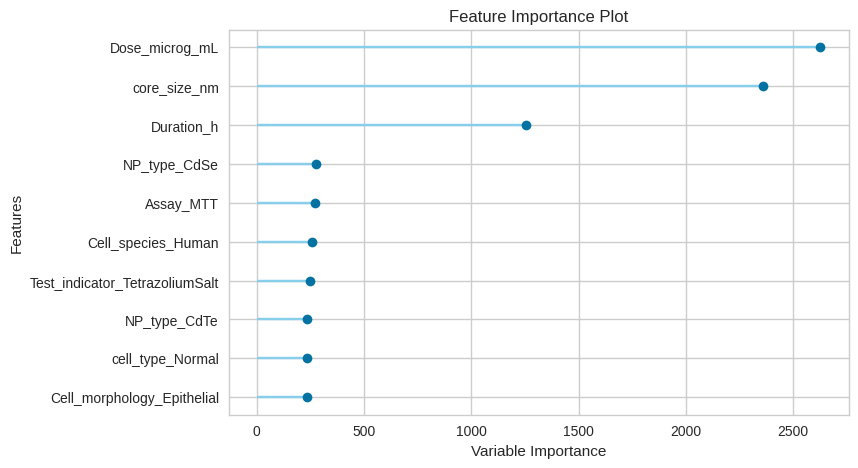

In [52]:
plot_model(tuned_models_load['lightgbm']._final_estimator, 'feature')